In [1]:
pip install vector uproot awkward

Note: you may need to restart the kernel to use updated packages.


In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward
import vector
plt.rcParams['figure.dpi'] = 100

import pandas as pd
import time
import vector

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

pot = 1.3e22
r_mue = 3e-17

seed_value = 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)


import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

In [3]:
file_ce = uproot.open("Mu2eDriftAmbigCeMinusTracks.root")
file_dio = uproot.open("Mu2eDriftAmbigFlatDIOTracks.root")
trks_ce = file_ce['trks']
trks_dio = file_dio['trks']
p_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                   "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                   "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                      "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                      "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
ce_tinfo = trks_ce['tinfo'].arrays(library='pd')
ce_tinfo['kkmidt0'] = trks_ce['kkmidt0'].arrays(library='pd')
ce_tinfo['kkmidmomerr'] = trks_ce['kkmidmomerr'].arrays(library='pd')
ce_tinfo['weight'] = trks_ce['weight'].array()
ce_tinfo['kkmidmom'] = vector.awk(p_ce).mag
ce_tinfo['mcmidmom'] = vector.awk(p_mc_ce).mag
ce_tinfo[ce_tinfo['kkstatus'] <= 1]
ce_tinfo['class'] = 1

dio_tinfo = trks_dio['tinfo'].arrays(library='pd')
dio_tinfo['kkmidt0'] = trks_dio['kkmidt0'].arrays(library='pd')
dio_tinfo['kkmidmomerr'] = trks_dio['kkmidmomerr'].arrays(library='pd')
dio_tinfo['weight'] = trks_dio['weight'].array()
dio_tinfo['kkmidmom'] = vector.awk(p_dio).mag
dio_tinfo['mcmidmom'] = vector.awk(p_mc_dio).mag
dio_tinfo['class'] = 0
dio_tinfo[dio_tinfo['kkstatus'] <= 1]
dio_tinfo = dio_tinfo
full = pd.concat([ce_tinfo, dio_tinfo],ignore_index=True)
good_quality = (full['kkstatus'] <= 1)
bad_quality = (full['kkstatus'] <= 1) 
full.head()
#I want to keep status, remove quality filter.


,ncells,narcs,ntrkhits,ncalohits,kkstatus,kkndof,kknbf,kknmat,kknhit,kkniter,kknactive,kknnull,kkchisq,kkprob,kkmidt0,kkmidmomerr,weight,kkmidmom,mcmidmom,class
0,42,3,41,1,0,46,74,42,42,0,39,13,70.016914,1.276834e-02,896.078186,0.119351,0.000319,104.953762,104.661412,1
1,42,3,40,1,0,44,79,42,41,0,39,11,57.068371,8.938216e-02,909.713684,0.157844,0.000319,104.003335,103.926295,1
2,65,4,61,1,0,70,93,65,62,0,62,14,77.811592,2.441538e-01,323.670502,0.112756,0.000319,103.478819,103.488916,1
3,64,3,60,1,0,70,103,64,61,0,51,25,191.830017,2.786454e-13,1063.765259,0.154282,0.000319,103.665509,103.707688,1
4,31,2,30,1,0,35,69,31,31,0,30,11,73.173729,1.652358e-04,406.672119,0.280964,0.000319,102.539806,104.489867,1


In [4]:
train_sample = full[good_quality | bad_quality]
train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)
train_sample['mcmidmom']= full['mcmidmom']
train_sample['kkmidmom']=full['kkmidmom']
test_size = 0.4
seed = 7
X, Y = train_sample.loc[:, train_sample.columns!=('mcmidmom')], train_sample['mcmidmom']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)



#exclude class and mcmidmom for features.
    
#Y = target = mcmidmom
#X = features:

X_train_df = X_train.loc[:, X_train.columns.isin(['kkmidmom','weight','kkmidt0','kkmidmomerr', 'kkprob', 'kkchisq','kknhit'])] #values im training with 
X_train_df.head()
#exclude weight

/tmp/ipykernel_1481/2596224862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)
/tmp/ipykernel_1481/2596224862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample['mcmidmom']= full['mcmidmom']
/tmp/ipykernel_1481/2596224862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,kknhit,kkchisq,kkprob,kkmidt0,kkmidmomerr,weight,kkmidmom
100710,28,56.862072,4.373383e-03,992.203003,0.193924,5.150114e-05,103.275870
34923,50,68.457619,2.974140e-01,301.782898,0.128694,3.193099e-04,103.083137
107082,54,170.394882,4.423994e-17,656.026062,0.200514,1.757699e-10,105.318778
41977,57,52.107594,6.587580e-01,1171.226074,0.156768,3.193099e-04,103.898849
107076,26,67.546295,2.493536e-05,954.496277,0.232564,1.121226e-05,104.821098


In [5]:
#regressor = LogisticRegression(C=1000, penalty='l1',solver='liblinear')
regressor=LinearRegression()
regressor.fit(X_train_df, y_train)
y_pred = regressor.predict(X_train_df)
#x_test or x_train?
#x_train_df and x_train different sizes

print('y_pred shape:', y_pred.shape)
print('y_test shape:', y_test.shape)

y_pred shape: (66090,)
y_test shape: (44060,)


In [6]:
#train_sample['mcmidmom']

In [7]:
#train_sample['kkmidmom']

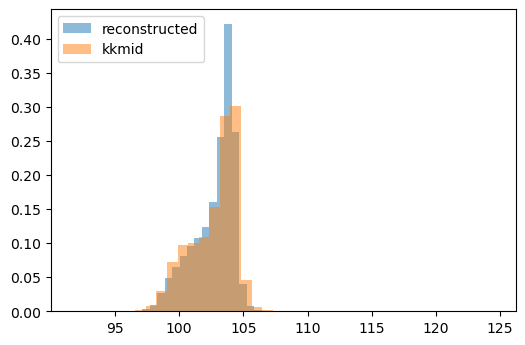

In [8]:
bins=40

plt.hist(y_pred, bins, alpha=0.5, label='reconstructed', density=True )
#plt.hist(y_test, bins, alpha=0.5, label='mcmid', density='True')
plt.hist(train_sample['kkmidmom'], bins, alpha=.5, label='kkmid', density=True )
#plt.hist(train_sample['mcmidmom'], bins, alpha=.5, label='mcmid', density='True' )
plt.legend(loc='upper left')

#y_pred/y_test different shape #should I be trying to get them to be the same shape or normalize/scale by density to 1 to compare the plot?
#Should I be comparing y_pred(reconstructed) with y_test(filtered mcmidmom), or y_pred with train_sample['mcmidmom']

#expect to see: mcmidmom biggest width, output (reconstructed) should be in between kkmid and mcmid

Text(0.5, 1.0, 'Linear Regressor')

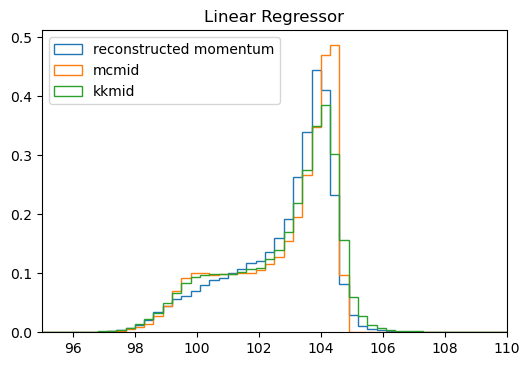

In [21]:
bins=50
plt.hist(y_pred, bins, alpha=1, label='reconstructed momentum', density=True, histtype='step',range=(95,110))
plt.hist(y_test, bins, alpha=1, label='mcmid', density=True, histtype='step',range=(95,110))
plt.hist(train_sample['kkmidmom'], bins, alpha=1, label='kkmid', density=True, histtype='step',range=(95,110))
plt.xlim(95,110)
plt.legend(loc='upper left')
plt.title('Linear Regressor')
#try keeping nhits affects energy/mom
#try with more complex regressors (MLPclassifier)

In [10]:
train_sample['mcmidmom']

0         104.661412
1         103.926295
2         103.488916
3         103.707688
4         104.489867
             ...    
112251    100.767704
112252    100.027463
112253     99.468345
112254    102.433835
112255     99.383904
Name: mcmidmom, Length: 110150, dtype: float64

In [11]:
train_sample.loc[:, train_sample.columns!=('mcmidmom')]

,ncells,narcs,ntrkhits,ncalohits,kkstatus,kkndof,kknbf,kknmat,kknhit,kkniter,kknactive,kknnull,kkchisq,kkprob,kkmidt0,kkmidmomerr,weight,kkmidmom,class,quality
0,42,3,41,1,0,46,74,42,42,0,39,13,70.016914,1.276834e-02,896.078186,0.119351,0.000319,104.953762,1,0
1,42,3,40,1,0,44,79,42,41,0,39,11,57.068371,8.938216e-02,909.713684,0.157844,0.000319,104.003335,1,1
2,65,4,61,1,0,70,93,65,62,0,62,14,77.811592,2.441538e-01,323.670502,0.112756,0.000319,103.478819,1,1
3,64,3,60,1,0,70,103,64,61,0,51,25,191.830017,2.786454e-13,1063.765259,0.154282,0.000319,103.665509,1,1
4,31,2,30,1,0,35,69,31,31,0,30,11,73.173729,1.652358e-04,406.672119,0.280964,0.000319,102.539806,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112251,36,3,35,1,0,40,99,36,36,0,34,12,115.065590,3.436063e-09,1904.692627,0.167662,0.327845,101.033412,0,0
112252,60,3,55,1,0,55,105,60,56,0,47,14,55.324127,4.623831e-01,479.316681,0.138605,0.871351,100.064075,0,1
112253,37,3,36,1,0,32,78,37,37,0,29,9,49.322273,2.588075e-02,1542.677368,0.264378,1.671128,99.102370,0,0
112254,19,2,18,1,0,20,69,19,19,0,19,7,46.704395,6.446082e-04,334.512177,0.262856,0.006383,101.797157,0,0


In [12]:

classifier = MLPRegressor(activation="relu",solver='adam',hidden_layer_sizes=(7,1),shuffle=False,random_state=7,early_stopping=True)
#shuffle = false so each run is consistent + random state = 7
X_train_df2 = X_train_df
y_train_2=y_train
classifier.fit(X_train_df2, y_train_2)
y_pred2 = classifier.predict(X_train_df2)
classifier.score(X_train_df2,y_train_2)
#find where to set epochs in parameter
#input layer = 7 #output = 1 #samples = 66090
#100,100 .81
#score x=feature set y=etc

#lower loss for score accuracy (pred vs target)
#plot loss as a fn of epoch training loss vs validation loss
#typically 60/20/20 split
#network is not converging 

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was

0.8771401818422053

Text(0.5, 1.0, 'Neural Network')

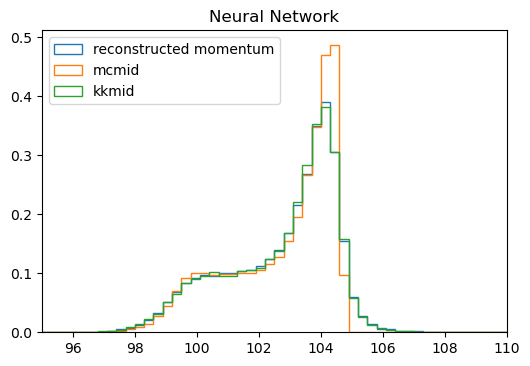

In [19]:
bins=50
plt.hist(y_pred2, bins,  label='reconstructed momentum', density=True, histtype='step', range=(95,110))
plt.hist(y_test, bins,  label='mcmid', density=True, histtype='step', range=(95,110))
plt.hist(X_test['kkmidmom'], bins,  label='kkmid', density=True, histtype='step',range=(95,110)) 
plt.legend(loc='upper left')
plt.xlim(95,110)
plt.title('Neural Network')

#how do I evaluate the performance of the neural network
#clarity of plot -- plot reco momentum vs mcmid/kkmid + clean up plots 
#keras deep learning library
#what to plot histogram with? i.e. entire sample for kkmidmom or training set
#test sample for comparison 
#X_train_df2['kkmidmom']
#y_train_2 = mcmidmom
#same range for binning (histogram)
#neural network output /mcmidmom output should be similiar

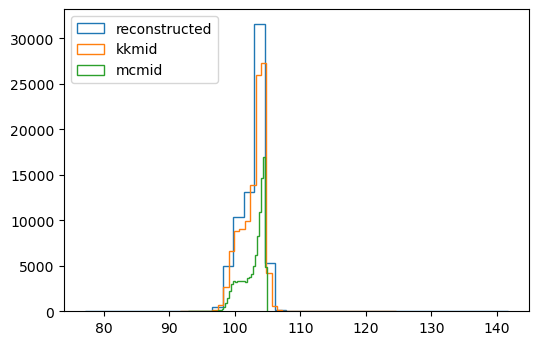

In [14]:
bins=40
plt.hist(y_pred2, bins, alpha=1, label='reconstructed', density=False,histtype='step' )
plt.hist(train_sample['kkmidmom'], bins, alpha=1, label='kkmid', density=False,histtype='step' )
plt.hist(train_sample['mcmidmom'], bins, alpha=1, label='mcmid', density=False,histtype='step' )
plt.legend(loc='upper left')
#same plot density false

In [15]:
y_pred2

array([103.2109989 , 103.1586917 , 105.52630255, ..., 103.76564921,
       101.62155696, 102.29092245])

In [16]:
train_sample['kkmidmom']

0         104.953762
1         104.003335
2         103.478819
3         103.665509
4         102.539806
             ...    
112251    101.033412
112252    100.064075
112253     99.102370
112254    101.797157
112255     98.757449
Name: kkmidmom, Length: 110150, dtype: float64

In [17]:
train_sample['mcmidmom']

0         104.661412
1         103.926295
2         103.488916
3         103.707688
4         104.489867
             ...    
112251    100.767704
112252    100.027463
112253     99.468345
112254    102.433835
112255     99.383904
Name: mcmidmom, Length: 110150, dtype: float64

In [18]:
score(X, Y[X, weight])

NameError: name 'score' is not defined

In [ ]:
weight=train_sample['weight']

In [ ]:
plt.plot(X_train,y_test)

In [ ]:
y_train_2

In [ ]:
y_test

In [ ]:
train_sample['mcmidmom']

In [ ]:
X_test['kkmidmom']

In [ ]:
len(y_pred)

In [ ]:
X_train_df2['kkmidmom']

In [ ]:
y_train_2

In [ ]:
X_test

In [ ]:
y_test

In [ ]:

plt.plot(classifier.loss_curve_, label='train')
plt.plot(classifier.validation_scores_,label='validation')
print(classifier.score(X_train_df2,y_train_2))
plt.legend()

In [ ]:
X_train_df2